# IV Calculation for call options

### BS Model

$C=\Phi(d_1)S - \Phi(d_2)Ke^{-rt}$ \
$P = \Phi(-d_2)Ke^{-rt} - \Phi(-d_1)S$ \
$d_1 = \frac{1}{\sigma \sqrt(t)}[log(\frac{S}{K}) + (r + \frac{\sigma^2}{2})t]$ \
$d_2 = d_1 - \sigma \sqrt(t) $


Say we have observed a call price $C_0$ \
and we are looking for a value $\sigma$, such that \
$\Phi(d_1)S - \Phi(d_2)Ke^{-rt} - C_0 = 0$


note that we need a derivative of C w.r.t $\sigma$ \
$\nu = \frac{\partial C}{\partial \sigma} = S \phi(d_1)\sqrt{t}$

We will use Newton's method(see Appendix)

In [42]:
from numpy import sqrt, exp, log, pi
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import datetime as dt
from datetime import date,datetime,timedelta
import warnings
#from scipy.interpolate import griddata
import plotly.graph_objects as go
from arch import arch_model
import nbformat
%matplotlib inline

In [43]:
import plotly.io as pio
pio.renderers.default = "notebook_connected"

In [44]:
warnings.filterwarnings("ignore")

### Black-Scholes formula, for a call option

In [45]:
def option_price(sigma, S, K, r, t,type = "c"):
    d1 = np.multiply( 1. / sigma * np.divide(1., np.sqrt(t)),
        np.log(S/K) + (r + sigma**2 / 2.) * t  )
    d2 = d1 - sigma * np.sqrt(t)
    C = np.multiply(S, norm.cdf(d1)) - \
        np.multiply(norm.cdf(d2) * K, np.exp(-r * t))
    P = np.multiply(norm.cdf(-d2) * K, np.exp(-r * t)) - \
        np.multiply(S,norm.cdf(-d1))
    if type == "c":
        return C
    elif type == "p":
        return P
    else:
        print("You must specify the type correctly (c or p)!!!")
    

### Objective function used for optimization

In [46]:
def objective_function(sigma, args):
    S = args[0]
    K = args[1]
    r = args[2]
    t = args[3]
    price = args[4]
    
    return option_price(sigma, S, K, r, t) - price

### Vega calculation

In [47]:
def calculate_vega(sigma, args):
    S = args[0]
    K = args[1]
    r = args[2]
    t = args[3]
    
    d1 = np.multiply( 1. / sigma * np.divide(1., np.sqrt(t)),
        np.log(S/K) + (r + sigma**2 / 2.) * t  )
    d2 = d1 - sigma * np.sqrt(t)
    
    return S * norm.pdf(d1) * np.sqrt(t)

### Newton's method

In [48]:
def newtons_method(f, fprime, R = 0, max_iter = 1000, tol=1e-3, args = [], debug = False):
    try:
        # Convert warnings to exceptions
        with warnings.catch_warnings():
            warnings.simplefilter("error", RuntimeWarning)
            count = 0
            epsilon = 1
    
            while epsilon >= tol:
                count += 1
                if count >= max_iter:
                    print('Forced exit, the loop runs away')
                    return (R, count)
        
                old_R = R
        
                function_value = f(R, args = args)
                function_derivative = fprime(R, args = args)
        
               
                R = -function_value / function_derivative + R
        
                epsilon = np.abs( (R - old_R) / old_R)
                if debug == True:
                    print('Iteration = ', count, 'f = ', function_value, 'fprime = ', function_derivative, 'Tol = ', epsilon)
        
            return R
    except RuntimeWarning:
        # Handle RuntimeWarnings here
        return None
    except Exception:
        # Handle all other exceptions here
        return 6969

# Get real data

#### Function to fetch data for options

#### We need:
1) option price c0
2) spot price S
3) strike price K
4) interest rate r
5) time to expiration t

In [49]:
def options_data(ticker,option_type = "call",oi_lower_bound=0):
    asset = yf.Ticker(ticker)
    exp_dates = asset.options #expiration dates for options
    data = pd.DataFrame() #dataframe for keeping of downloaded options
    for exp in exp_dates:
        options = asset.option_chain(exp)
        calls = options.calls
        calls["optionType"] = "call"
        puts = options.puts
        puts["optionType"] = "put"
        d = pd.concat([calls,puts])
        d["expiration"] = pd.to_datetime(exp)+pd.DateOffset(hours=23,minutes=59,seconds=59)
        data = pd.concat([data,d])
    data["dte"] = (data["expiration"] - dt.datetime.today()).dt.days + 1
    data = data[["strike","lastPrice","volume","openInterest","optionType","dte","impliedVolatility"]]
    data = data[data["openInterest"]>oi_lower_bound]
    if option_type == "call":
        call_chain = data[data["optionType"] == "call"]
        return call_chain
    elif option_type == "put":
        put_chain = data[data["optionType"] == "call"]
        return put_chain
    else:
        return data


### Example for AAPL

In [50]:
aapl_c = options_data("AAPL",oi_lower_bound=0)

In [51]:
aapl_c.head()

,strike,lastPrice,volume,openInterest,optionType,dte,impliedVolatility
0,5.0,227.35,6.0,1567,call,4,0.00001
1,10.0,240.87,1.0,29,call,4,0.00001
2,15.0,218.45,2.0,168,call,4,0.00001
3,20.0,216.57,25.0,69,call,4,0.00001
4,25.0,216.26,1.0,77,call,4,0.00001


In [52]:
S_aapl = yf.download("AAPL")["Close"].iloc[-1].iat[-1]
r_1y = yf.download("^IRX")["Close"].iloc[-1].iat[-1]/100

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### Calculation of implied volatility for aapl_c dataframe

In [53]:
aapl_c["iv"] = aapl_c.apply(lambda row: newtons_method(objective_function,calculate_vega,0.5,
                                                       args=(S_aapl,row["strike"],r_1y,float(row["dte"]/365),row["lastPrice"])),axis = 1)

Forced exit, the loop runs away


#### A test with fixed arguemnts

In [54]:
S = S_aapl                   #  Index price
K = 250.0             #  Strike price
r = r_1y                      #  Risk-free rate
t = 3.0/365.0                    #  Time until expiration
C0 = 0.05      #  Call price taken to be the midprice between the bid and ask

args = (S, K, r, t, C0)  
newtons_method(objective_function,calculate_vega,0.5,args=args) 

np.float64(0.3193413447600543)

### Surface plot

In [55]:
aapl_c_ = aapl_c.dropna()

In [56]:
def plot_iv_values(data):
    x = data['strike'].values
    y = data['dte'].values
    z = data['iv'].values

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(x, y, z, c=z, cmap='viridis')

    ax.set_xlabel('Strike prices')
    ax.set_ylabel('DTE (Days to Expiration)')
    ax.set_zlabel('IV (Implied Volatility)')

    ax.set_title('IV of the stock')

    plt.show()


ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not array([np.float64(0.18785008264961395), np.float64(0.2156277518258605),
       np.float64(0.22309498581437862), np.float64(0.2260515068046058),
       np.float64(0.23151974036858186), np.float64(0.23330719543365372),
       np.float64(0.23284524281870594), np.float64(0.2433697800379833),
       np.float64(0.2566500328846923), np.float64(0.27842394958151123),
       np.float64(0.31259775388448413), np.float64(0.3205385736802682),
       np.float64(0.3513222795191927), np.float64(0.38153478318421447),
       np.float64(0.4112180637387185), np.float64(0.4404053556985102),
       np.float64(0.46912596211330077), np.float64(0.4974029318323876),
       np.float64(0.5252604551853706), np.float64(0.5527162626444349),
       np.float64(0.5797885505774283), np.float64(0.6064907963064797),
       np.float64(0.6328400389302473), np.float64(0.6845286367065079),
       np.float64(0.7349422301902885), np.float64(1.01584071724476),
       np.float64(0.8582676255965029),
       (np.float64(1.1388145946535957), 1000),
       np.float64(0.20087155585241917), np.float64(0.20839350363989764),
       np.float64(0.2006469294262918), np.float64(0.20479500207135243),
       np.float64(0.20586127275833346), np.float64(0.20402371582685264),
       np.float64(0.20625578138270703), np.float64(0.2079994444913022),
       np.float64(0.2159595516843403), np.float64(0.21865163871000065),
       np.float64(0.22787763077415185), np.float64(0.23775227242907893),
       np.float64(0.2536399682363938), np.float64(0.2607026322429331),
       np.float64(0.2674663691797956), np.float64(0.2961093393523747),
       np.float64(0.29716257701183485), np.float64(0.31620655569092204),
       np.float64(0.35337389814519277), np.float64(0.3727973378785673),
       np.float64(0.38016108962684375), np.float64(0.4113410451220773),
       np.float64(0.4417519924731493), np.float64(0.47144238621929563),
       np.float64(0.5004539809304386), np.float64(0.5288207087831038),
       np.float64(0.5565804675525649), np.float64(0.5837614507856121),
       np.float64(0.7034684648247879), np.float64(2.0669473079378093),
       np.float64(0.25576625038955514), np.float64(0.23882654513604246),
       np.float64(0.2788722342728809), np.float64(0.2724040734295124),
       np.float64(0.2691908570945089), np.float64(0.26626885618276463),
       np.float64(0.2681032600668124), np.float64(0.27211795282687196),
       np.float64(0.27873094578148844), np.float64(0.288663915216803),
       np.float64(0.3058559806608746), np.float64(0.3156129861256758),
       np.float64(0.32905012631584146), np.float64(0.3503983290907469),
       np.float64(0.36869367149034793), np.float64(0.3831430111700945),
       np.float64(0.40845504275636063), np.float64(0.4159085167194376),
       np.float64(0.4122979072394826), np.float64(0.462133022581501),
       np.float64(0.48450180740653104), np.float64(0.5064081171945563),
       np.float64(0.5278721007039449), np.float64(1.5437664832792735),
       np.float64(1.2801333906532437), np.float64(0.2503149469806078),
       np.float64(0.26089085495157677), np.float64(0.22086610711928475),
       np.float64(0.2455540016027091), np.float64(0.2509583926629664),
       np.float64(0.2586404019522936), np.float64(0.2566752747090116),
       np.float64(0.2558628557076174), np.float64(0.2548472124024959),
       np.float64(0.25312016998281206), np.float64(0.25972532538521764),
       np.float64(0.26896046675398655), np.float64(0.2772835472521564),
       np.float64(0.287306375780084), np.float64(0.3014598615895723),
       np.float64(0.30873985294851547), np.float64(0.31988854264795724),
       np.float64(0.32406961698251985), np.float64(0.3316247285240308),
       np.float64(0.36652926641076256), np.float64(0.37175575473769695),
       np.float64(0.3673362828229653), np.float64(0.4101409691603738),
       np.float64(0.4287336860061487), np.float64(0.4469502263445317),
       np.float64(0.24613556736510478), np.float64(0.23250507058982006),
       np.float64(0.2431639539756602), np.float64(0.24239637939655903),
       np.float64(0.2413336908649833), np.float64(0.24195500267687636),
       np.float64(0.24381299483265959), np.float64(0.24553013125057133),
       np.float64(0.24627909549972066), np.float64(0.25896917818381465),
       np.float64(0.2668181695585279), np.float64(0.27183544699053086),
       np.float64(0.29219223002166755), np.float64(0.29847881754165356),
       np.float64(0.32201381588916195), np.float64(0.33307094614593474),
       np.float64(0.3762260033671036), np.float64(0.4048811400159127),
       np.float64(0.3942007415921655), np.float64(0.7823746702595571),
       np.float64(0.8004151639647239), np.float64(0.8316389348617798),
       np.float64(0.23731139832410483), np.float64(0.24146419687495227),
       np.float64(0.2402119655591569), np.float64(0.23729044387694107),
       np.float64(0.23509309462317116), np.float64(0.23350622710968105),
       np.float64(0.2308962116548817), np.float64(0.22924852500031928),
       np.float64(0.2304639580143358), np.float64(0.23300458547535083),
       np.float64(0.23744561521317795), np.float64(0.24256740637258783),
       np.float64(0.25120191158417465), np.float64(0.2576316691379424),
       np.float64(0.266722918516599), np.float64(0.2735872753695236),
       np.float64(0.28874995733896586), np.float64(0.3025569000450696),
       np.float64(0.3083814647882363), np.float64(0.32552587287271423),
       np.float64(0.32428664481374875), np.float64(0.3399894651697061),
       np.float64(0.3417115666170557), np.float64(0.3563043353941537),
       np.float64(0.37061006533329266), np.float64(0.3846396225812593),
       np.float64(0.37516118538112136), np.float64(0.41191889578212815),
       np.float64(0.42519005091684575), np.float64(0.4382247024296066),
       np.float64(0.4510349807819578), np.float64(0.43730078965831487),
       np.float64(0.4491076444715661), np.float64(0.5063602148260993),
       np.float64(0.5385455595718114), np.float64(0.4899431800540495),
       np.float64(0.4011322758850456), np.float64(0.2178256003078238),
       np.float64(0.21272709352679986), np.float64(0.21926931027330082),
       np.float64(0.23315484745733847), np.float64(0.23228595838394858),
       np.float64(0.22625709341862), np.float64(0.2270350992398258),
       np.float64(0.22635930822459202), np.float64(0.22797399109893346),
       np.float64(0.2314442639407404), np.float64(0.2405898723462477),
       np.float64(0.24395376381814557), np.float64(0.2556523586288231),
       np.float64(0.2610088089603405), np.float64(0.26096656336385604),
       np.float64(0.2690415842637522), np.float64(0.2944415178487826),
       np.float64(0.7569096865321976), np.float64(0.708859181931198),
       np.float64(0.7023509865134714), np.float64(0.673912856385908),
       np.float64(0.19013073742040137), np.float64(0.22645444377297777),
       np.float64(0.22606381527070155), np.float64(0.2400327524681616),
       np.float64(0.22689129986845047), np.float64(0.23243887653856352),
       np.float64(0.2284679067985958), np.float64(0.22379269718007438),
       np.float64(0.22097734268731462), np.float64(0.21934564296946626),
       np.float64(0.21892029733073354), np.float64(0.2184837433480955),
       np.float64(0.22063867026667716), np.float64(0.2216879796057084),
       np.float64(0.22761104897230486), np.float64(0.22986897598311803),
       np.float64(0.2395414411381593), np.float64(0.2433508931010884),
       np.float64(0.25219273777542606), np.float64(0.25858878787293355),
       np.float64(0.2731377204148933), np.float64(0.28596703209939545),
       np.float64(0.29532104122799585), np.float64(0.31858543482220825),
       np.float64(0.33327017043025037), np.float64(0.34468691459877643),
       np.float64(0.35144203236707716), np.float64(0.34934621311180003),
       np.float64(0.4249232501048226), np.float64(0.8327185906386586),
       np.float64(0.6575223843845104), np.float64(1.2271428007107217),
       np.float64(0.9774191865174663), np.float64(0.9670524646599639),
       np.float64(0.989973589771472), np.float64(0.8540661594258306),
       np.float64(0.41431699458334803), np.float64(0.21117079086321933),
       np.float64(0.21597741876275717), np.float64(0.20763792606897696),
       np.float64(0.2290274324069551), np.float64(0.2263442136754544),
       np.float64(0.2328375333941312), np.float64(0.22809017372793483),
       np.float64(0.22585528935825117), np.float64(0.21987876225051364),
       np.float64(0.2184833998695912), np.float64(0.21596708499143236),
       np.float64(0.20763353689028316), np.float64(0.21185199569738503),
       np.float64(0.20880931540505976), np.float64(0.21213034394648062),
       np.float64(0.21261579966110467), np.float64(0.21476864964179712),
       np.float64(0.2182424437179218), np.float64(0.22397662078525182),
       np.float64(0.22855164032849068), np.float64(0.23224753467716064),
       np.float64(0.24015565532398225), np.float64(0.23931530005618878),
       np.float64(0.24937757606147978), np.float64(0.2514941197882085),
       np.float64(0.27036858305194317), np.float64(0.2736612657891123),
       np.float64(0.27468586618923013), np.float64(0.28107587847900445),
       np.float64(0.532404624076191), np.float64(0.5143757961369542),
       np.float64(0.3873002940127814), np.float64(0.292018305509322),
       np.float64(0.23447407744561227), np.float64(0.22272056112876085),
       np.float64(0.23188440693394086), np.float64(0.2308945841644565),
       np.float64(0.23030331573043364), np.float64(0.22653691902497594),
       np.float64(0.2384084011555407), np.float64(0.2321905407545353),
       np.float64(0.22395052287552417), np.float64(0.2270162594333956),
       np.float64(0.2188511172499289), np.float64(0.21633304457230562),
       np.float64(0.2198749628986339), np.float64(0.21514868558783568),
       np.float64(0.21535658528855128), np.float64(0.21759775924238586),
       np.float64(0.21567869963989741), np.float64(0.21905002901311277),
       np.float64(0.2166160042953622), np.float64(0.2286820990536587),
       np.float64(0.22111830655409942), np.float64(0.23501187005185675),
       np.float64(0.23527786925828786), np.float64(0.2379185719915594),
       np.float64(1.1247043420748009), np.float64(0.5545855657050579),
       np.float64(0.47309467412695183), np.float64(0.7951896398420416),
       np.float64(0.20611678397324956), np.float64(0.19201368463384894),
       np.float64(0.21967161725810488), np.float64(0.21306550228974025),
       np.float64(0.23980879921989098), np.float64(0.23683167895053422),
       np.float64(0.22446392870822132), np.float64(0.23865254860630325),
       np.float64(0.24848725224553694), np.float64(0.23412694453052324),
       np.float64(0.22830043843388548), np.float64(0.23663208893870472),
       np.float64(0.2314733336526438), np.float64(0.22704534749574612),
       np.float64(0.21991156061338313), np.float64(0.222412549891462),
       np.float64(0.21609242426935013), np.float64(0.21757671967518175),
       np.float64(0.216419433028768), np.float64(0.211716285134897),
       np.float64(0.211300966999286), np.float64(0.21502248261258666),
       np.float64(0.2120746550881118), np.float64(0.2108939345020629),
       np.float64(0.2159840792404072), np.float64(0.21871891393824708),
       np.float64(0.22088383515929744), np.float64(0.22692906040951363),
       np.float64(0.23355781171290213), np.float64(0.2370343070784757),
       np.float64(0.24792225581137603), np.float64(0.25684304317645584),
       np.float64(0.9235414947650118), np.float64(0.8967311103223735),
       np.float64(0.8101311069417171), np.float64(1.0400646988889244),
       np.float64(0.7537969663554425), np.float64(0.8520224224059587),
       np.float64(0.7986854804414909), np.float64(0.8534653298827394),
       np.float64(0.5952993633607196), np.float64(0.2020091628098425),
       np.float64(0.2700120085433034), np.float64(0.24441900412274992),
       np.float64(0.23795400705528505), np.float64(0.23472430036003852),
       np.float64(0.2327393273236349), np.float64(0.2340396850043655),
       np.float64(0.2008694542004682), np.float64(0.2328504271274018),
       np.float64(0.224172221392552), np.float64(0.22260298879195137),
       np.float64(0.21726446276009595), np.float64(0.21653682895653534),
       np.float64(0.21422635164220824), np.float64(0.2140997855497136),
       np.float64(0.21296740191699684), np.float64(0.21056722645382975),
       np.float64(0.2096169713308669), np.float64(0.21265286113488538),
       np.float64(0.20947969470231323), np.float64(0.2049957706758263),
       np.float64(0.21186845211426433), np.float64(0.2149189050236674),
       np.float64(0.21380013684613952), np.float64(0.22155404331457332),
       np.float64(0.22660117609455088), np.float64(0.22130747713416846),
       np.float64(0.21968831272894251), np.float64(0.22434573179004072),
       np.float64(0.23001396025554777), np.float64(0.24588658296535976),
       np.float64(0.25718153582592995), np.float64(0.26406997196030807),
       np.float64(0.2704604331255203), np.float64(0.26927124925210155),
       np.float64(0.2751961341429448), np.float64(0.5678872530989891),
       np.float64(1.1983463868637332), np.float64(1.155347055132153),
       np.float64(0.4944805189321918), np.float64(1.21136099774983),
       np.float64(0.9220553157129731), np.float64(0.3389669452621635),
       np.float64(0.33288770267215484), np.float64(0.2521774333181542),
       np.float64(0.235681954268625), np.float64(0.22487550560782424),
       np.float64(0.23469171895521468), np.float64(0.2117978126272437),
       np.float64(0.23418946797186344), np.float64(0.2326207111317612),
       np.float64(0.2338750847413183), np.float64(0.2276967108123276),
       np.float64(0.22583244092931296), np.float64(0.22229867129916037),
       np.float64(0.22185110277408499), np.float64(0.2205415608154001),
       np.float64(0.21889591612721898), np.float64(0.21829005881576102),
       np.float64(0.21464993337102106), np.float64(0.21471152607945437),
       np.float64(0.21309155252772463), np.float64(0.21394783161526013),
       np.float64(0.21153117812198485), np.float64(0.20792376788168646),
       np.float64(0.215582297930184), np.float64(0.21310498968802932),
       np.float64(0.2125402809255628), np.float64(0.21215828434428746),
       np.float64(0.22176764765738166), np.float64(0.2391633119360577),
       np.float64(0.24178296368783098), np.float64(0.23003007442394774),
       np.float64(0.23495127238962824), np.float64(0.24299356638562042),
       np.float64(0.2503712332534992), np.float64(0.2608137680130212),
       np.float64(0.7538747832837217), np.float64(0.9923076732272037),
       np.float64(0.8588973151748913), np.float64(1.1786479043407878),
       np.float64(0.8669045808457396), np.float64(0.8967574052757159),
       np.float64(0.6914625099607383), np.float64(0.9117937514615212),
       np.float64(0.7877406900629572), np.float64(0.6165296304578145),
       np.float64(0.3412584832583711), np.float64(0.28071244668361334),
       np.float64(0.26282448567611366), np.float64(0.4510121063683665),
       np.float64(0.2632905724942554), np.float64(0.24473963076745822),
       np.float64(0.20407860105851866), np.float64(0.19190434633384332),
       np.float64(0.18761840324047188), np.float64(0.19370622899157686),
       np.float64(0.22651656440772722), np.float64(0.24293654096176687),
       np.float64(0.24217922897936697), np.float64(0.2361144152623056),
       np.float64(0.23435137922436644), np.float64(0.23147161598680435),
       np.float64(0.22594942838810175), np.float64(0.22452409197659315),
       np.float64(0.22607472700283468), np.float64(0.22528485694210038),
       np.float64(0.21772080485957504), np.float64(0.21532330795849702),
       np.float64(0.21841561066664522), np.float64(0.2166043827103266),
       np.float64(0.21666272383245141), np.float64(0.20999280778700719),
       np.float64(0.21337067271737245), np.float64(0.20486441083428156),
       np.float64(0.21439132878021028), np.float64(0.21349134053682872),
       np.float64(0.2105476485534803), np.float64(0.21638215453233992),
       np.float64(0.2200411262007827), np.float64(0.22469887661664256),
       np.float64(0.22868227115182427), np.float64(0.23645030370559564),
       np.float64(0.24138986498590034), np.float64(0.243627572441982),
       np.float64(0.26030601143093945), np.float64(0.4247207391272095),
       np.float64(0.4139618058574936), np.float64(0.34221370406172336),
       np.float64(0.2518656972673747), np.float64(0.20222236310265934),
       np.float64(0.27203584649455276), np.float64(0.21084449439489703),
       np.float64(0.25310861944045193), np.float64(0.2260992048757345),
       np.float64(0.23137577325618683), np.float64(0.22652991768711675),
       np.float64(0.20638313629703176), np.float64(0.22188282913875768),
       np.float64(0.22055310554767626), np.float64(0.21923602757123248),
       np.float64(0.21620519798818283), np.float64(0.21517322566931887),
       np.float64(0.20249000469181358), np.float64(0.21445381525218435),
       np.float64(0.213052998301567), np.float64(0.20681987165286742),
       np.float64(0.20760245319499432), np.float64(0.21598086914065628),
       np.float64(0.22924989480620128), np.float64(0.23093031921589513),
       np.float64(0.2286264922661834), np.float64(1.0240939559372517),
       np.float64(0.9599725867976118), np.float64(0.8146013229764211),
       np.float64(0.9511136381953706), np.float64(1.0414796654905911),
       np.float64(0.9217040550493917), np.float64(0.7012023704078103),
       np.float64(0.31392512510823045), np.float64(0.8075940861493306),
       np.float64(0.5783710210513157), np.float64(0.5500019097352048),
       np.float64(0.35017551277689435), np.float64(0.33406136807668735),
       np.float64(0.2603780263780767), np.float64(0.19324519392859416),
       np.float64(0.17113011999131053), np.float64(0.255463427633629),
       np.float64(0.19805528865016), np.float64(0.25307468301432917),
       np.float64(0.2551235324283637), np.float64(0.2014544183894499),
       np.float64(0.24956401504003947), np.float64(0.22262550228443295),
       np.float64(0.24617591095063265), np.float64(0.24025342973963254),
       np.float64(0.23771451887362038), np.float64(0.23904760441638756),
       np.float64(0.23201890387975174), np.float64(0.23181492936903228),
       np.float64(0.2323466575349395), np.float64(0.22494025137986803),
       np.float64(0.2256453893204749), np.float64(0.22229782879849916),
       np.float64(0.22077690317474347), np.float64(0.21974141930928073),
       np.float64(0.22112181484008608), np.float64(0.21887918396030018),
       np.float64(0.2183104741301671), np.float64(0.21216648014958464),
       np.float64(0.21786832632176373), np.float64(0.21232818114377924),
       np.float64(0.21190866115136794), np.float64(0.21600188657945343),
       np.float64(0.22197871090281882), np.float64(0.2220837884281824),
       np.float64(0.23881340815282415), np.float64(0.22720687737776554),
       np.float64(0.2348538351064629), np.float64(0.23614611299420907),
       np.float64(0.23955696478587055), np.float64(0.7586205060892223),
       np.float64(1.0200575871769864), np.float64(1.1162702126128736),
       np.float64(0.7073043290618297), np.float64(0.40711155823471784),
       np.float64(0.40716900520199434), np.float64(0.41544052886950317),
       np.float64(0.19396070251741607), np.float64(0.22328987347224993),
       np.float64(0.2901715910456361), np.float64(0.45076641444111354),
       np.float64(0.25749054482239586), np.float64(0.24931423808460945),
       np.float64(0.1615826444490722), np.float64(0.1866808419902571),
       np.float64(0.2727350986857422), np.float64(0.25626573220997567),
       np.float64(0.2554554054279181), np.float64(0.2525430596863669),
       np.float64(0.2509687248058513), np.float64(0.24617714820213138),
       np.float64(0.25121621089709933), np.float64(0.2403762514838718),
       np.float64(0.23740033384626144), np.float64(0.23882786811679912),
       np.float64(0.2348695501290894), np.float64(0.23064586735477413),
       np.float64(0.23206223277946106), np.float64(0.2269820954341784),
       np.float64(0.22883466406445452), np.float64(0.2260621696089122),
       np.float64(0.2219167457240297), np.float64(0.2220456369037572),
       np.float64(0.22124692596891182), np.float64(0.2185151385797789),
       np.float64(0.21718680216633265), np.float64(0.21755799453234695),
       np.float64(0.21709783409634545), np.float64(0.21680202699983236),
       np.float64(0.2171060788800763), np.float64(0.21800447343616491),
       np.float64(0.22075356016992378), np.float64(0.22179739586678235),
       np.float64(0.2228569436772176), np.float64(0.23277225052881179),
       np.float64(0.23270698823702116), np.float64(0.8941353484256375),
       np.float64(1.0658999595965213), np.float64(0.8642201170211908),
       np.float64(0.6247201345692819), np.float64(0.7603649801323507),
       np.float64(0.7813937840041856), np.float64(0.377324772749846),
       np.float64(0.5080682820949041), np.float64(0.3550727153980328),
       np.float64(0.5809413171032295), np.float64(0.2609878206101813),
       np.float64(0.26127453385924454), np.float64(0.5848141792680704),
       np.float64(0.2195897566481357), np.float64(0.3144374534497811),
       np.float64(0.2633798184001981), np.float64(0.2661517666144645),
       np.float64(0.3680570608181468), np.float64(0.2816949716704357),
       np.float64(0.25093297039154433), np.float64(0.2502161884830843),
       np.float64(0.2217980596277778), np.float64(0.2216120982887607),
       np.float64(0.24205212418801736), np.float64(0.24037062309895513),
       np.float64(0.23595702612942218), np.float64(0.23855099741499772),
       np.float64(0.23738937777486133), np.float64(0.23228381801488357),
       np.float64(0.2341947300839701), np.float64(0.23220024288688057),
       np.float64(0.22835502026046825), np.float64(0.22900048940542253),
       np.float64(0.22918594772176912), np.float64(0.2263989068948402),
       np.float64(0.2242496513563787), np.float64(0.22146821668746064),
       np.float64(0.2221386642310234), np.float64(0.22098048358582306),
       np.float64(0.21339045829129524), np.float64(0.21866333200758395),
       np.float64(0.21250252946210144), np.float64(0.2194996943428453),
       np.float64(0.21986361468026297), np.float64(0.23310686903735925),
       np.float64(0.21642347460736788), np.float64(0.22523144970753178),
       np.float64(0.22372267040767066), np.float64(0.7450333316895973),
       np.float64(0.5767154775244221), np.float64(0.9868276732955745),
       np.float64(0.7366530455666804), np.float64(0.7920789015987307),
       np.float64(0.5496459873604946), np.float64(0.8230184009471859),
       np.float64(0.557182394105668), np.float64(0.6887111884111197),
       np.float64(0.4909465014895942), np.float64(0.4779989072668384),
       np.float64(0.47232411103508326), np.float64(0.48106656046439894),
       np.float64(0.2512221084160579), np.float64(0.4906082510027877),
       np.float64(0.241949865092605), np.float64(0.22582705698831046),
       np.float64(0.2120566694264831), np.float64(0.21485928769952498),
       np.float64(0.2785640740216111), np.float64(0.2516694794721212),
       np.float64(0.2554036882407981), np.float64(0.2472996838604966),
       np.float64(0.23888120234973478), np.float64(0.24787991041222876),
       np.float64(0.23820757817065585), np.float64(0.23358342001344026),
       np.float64(0.23190552952343255), np.float64(0.22889998109321388),
       np.float64(0.22623173955682369), np.float64(0.21905537739914188),
       np.float64(0.22258213247308342), np.float64(0.21306321302335898),
       np.float64(0.22613949592947094), np.float64(0.2155662632056906),
       np.float64(0.21173079847091375), np.float64(0.21770875648324162),
       np.float64(0.21969652802890516), np.float64(0.22417504913079656),
       np.float64(0.23294925983301498), np.float64(0.21352144553240185),
       np.float64(0.21985796933000776), np.float64(0.23035578031366635),
       np.float64(0.22143173181645015), np.float64(0.22827256673758323),
       np.float64(0.22332717750998052), np.float64(0.22481454350039368),
       np.float64(0.8334519245703134), np.float64(0.8727702146288021),
       np.float64(0.6404141084323391), np.float64(0.6068676899383262),
       np.float64(0.3118236674672575), np.float64(0.8365722915555263),
       np.float64(0.3554606990208751), np.float64(0.30945663539751184),
       np.float64(0.3798987586250332), np.float64(0.32154074596664534),
       np.float64(0.24984171556317303), np.float64(0.38776788935370254),
       np.float64(0.37670001967553074), np.float64(0.39225184321114603),
       np.float64(0.2312150578912649), np.float64(0.28457558929267157),
       np.float64(0.25729026149482004), np.float64(0.22682026585755197),
       np.float64(0.25600826876877797), np.float64(0.28394114335063186),
       np.float64(0.24919900859777952), np.float64(0.25025576851962933),
       np.float64(0.25060632569651087), np.float64(0.24072651800833342),
       np.float64(0.2419164978426104), np.float64(0.23452610870545962),
       np.float64(0.23483092489120394), np.float64(0.22900345016673998),
       np.float64(0.22585008520130562), np.float64(0.22437369928298123),
       np.float64(0.22064789846746946), np.float64(0.21448075736821373),
       np.float64(0.21858391319302317), np.float64(0.21798454471769765),
       np.float64(0.21966882515317274), np.float64(0.21710465555014202),
       np.float64(0.22203736032272933), np.float64(0.21163338689263006),
       np.float64(0.21331557957557296), np.float64(0.21800684813526883),
       np.float64(0.21800192194245452), np.float64(0.22407699199509523),
       np.float64(0.21869119595728187), np.float64(0.21793677163279368),
       np.float64(0.22143665545787064), np.float64(0.22268655545744287)],
      dtype=object)

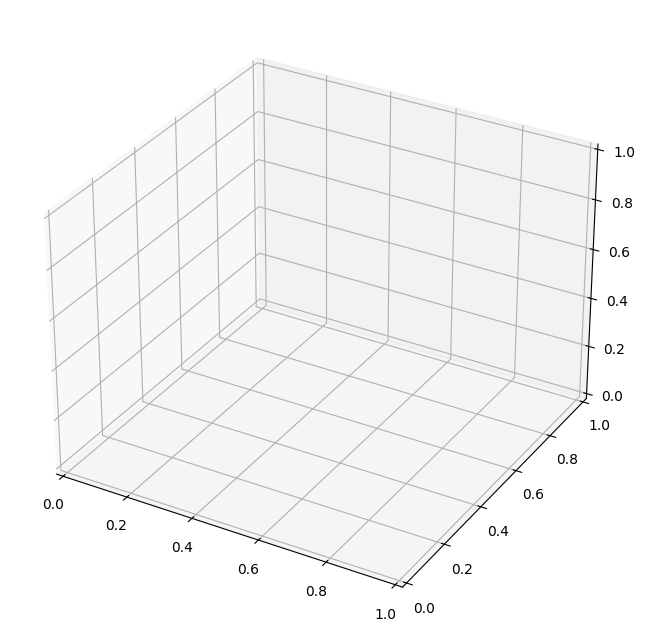

In [57]:
x = aapl_c_['strike'].values
y = aapl_c_['dte'].values
z = aapl_c_['iv'].values

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, c=z, cmap='viridis')

ax.set_xlabel('Strike prices')
ax.set_ylabel('DTE (Days to Expiration)')
ax.set_zlabel('IV (Implied Volatility)')

ax.set_title('IV of the stock')

plt.show()

# Interactive Plot

In [17]:
def plot_iv_values_inter(d):
    fig3 = go.Figure(
        data=[
            go.Scatter3d(
                x=aapl_c_["strike"],  # X-axis
                y=aapl_c_["dte"],     # Y-axis
                z=aapl_c_["iv"],      # Z-axis
                mode='markers',
                marker=dict(
                    size=5,
                    color=aapl_c_["iv"],  # Color by "iv" values
                    colorscale='Viridis',  # Color scale
                    opacity=0.8
                )
            )
        ]
    )

# Customize layout
    fig3.update_layout(
        title="Interactive 3D Scatter Plot",
        scene=dict(
            xaxis_title="Strike",
            yaxis_title="DTE",
            zaxis_title="IV"
        ),
        margin=dict(l=0, r=0, b=0, t=40)
    )

# Show the plot
    return fig3.show()

In [ ]:
fig3 = go.Figure(
    data=[
        go.Scatter3d(
            x=aapl_c_["strike"],  # X-axis
            y=aapl_c_["dte"],     # Y-axis
            z=aapl_c_["iv"],      # Z-axis
            mode='markers',
            marker=dict(
                size=5,
                color=aapl_c_["iv"],  # Color by "iv" values
                colorscale='Viridis',  # Color scale
                opacity=0.8
            )
        )
    ]
)

# Customize layout
fig3.update_layout(
    title="Interactive 3D Scatter Plot",
    scene=dict(
        xaxis_title="Strike",
        yaxis_title="DTE",
        zaxis_title="IV"
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

# Show the plot
fig3.show()

## Alternatively, as a surface

TypeError: int() argument must be a string, a bytes-like object or a real number, not 'tuple'

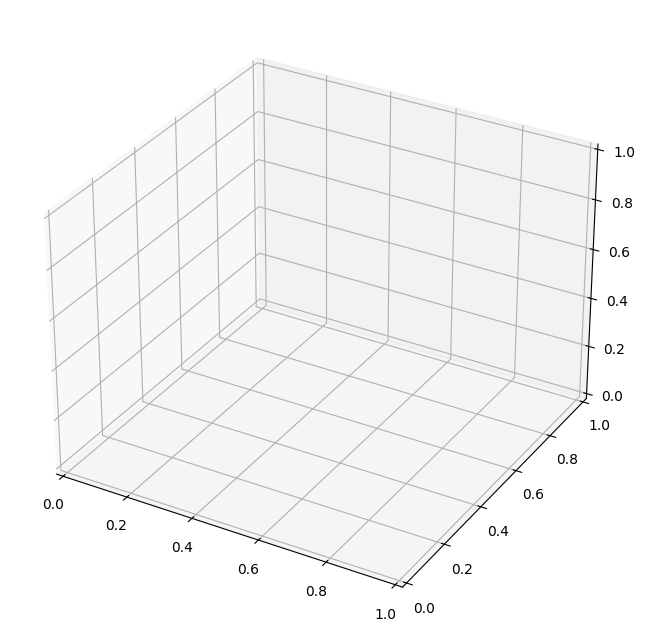

In [58]:
fig2 = plt.figure(figsize=(12,8))

ax2 = fig2.add_subplot(111,projection = "3d")

surf = ax2.plot_trisurf(x,y,z,cmap = "viridis")

ax2.set_xlabel("Strike")
ax2.set_ylabel("DTE")
ax2.set_zlabel("IV")

ax2.set_title("Implied Volatility")
fig2.colorbar(surf)
plt.show()

### Volatility Measures

#### Historical Volatility

In [59]:
def hist_vol(ticker,window):
    ticker_data = yf.download(ticker)
    ticker_data = ticker_data.Close
    log_ret = np.log(ticker_data/ticker_data.shift())
    hist_vol = (log_ret.rolling(window).std().dropna())*np.sqrt(252)
    last_30_values = hist_vol[-30:]
    last_value = round(hist_vol.iloc[-1,-1],4)
    print(f"The last value of historical volatility based on {window}-day window is {last_value}")

    fig,ax = plt.subplots(figsize = (14,6))
    ax.plot(last_30_values,label = "Line Plot",color = "black")
    ax.set_title(f"{window}-day historical volatility values (annualized)",fontsize = 20)
    ax.set_xlabel("Date")
    ax.set_ylabel("Volatility")
    ax.legend()
    return plt.show(fig)

[*********************100%***********************]  1 of 1 completed

The last value of historical volatility based on 30-day window is 0.1854


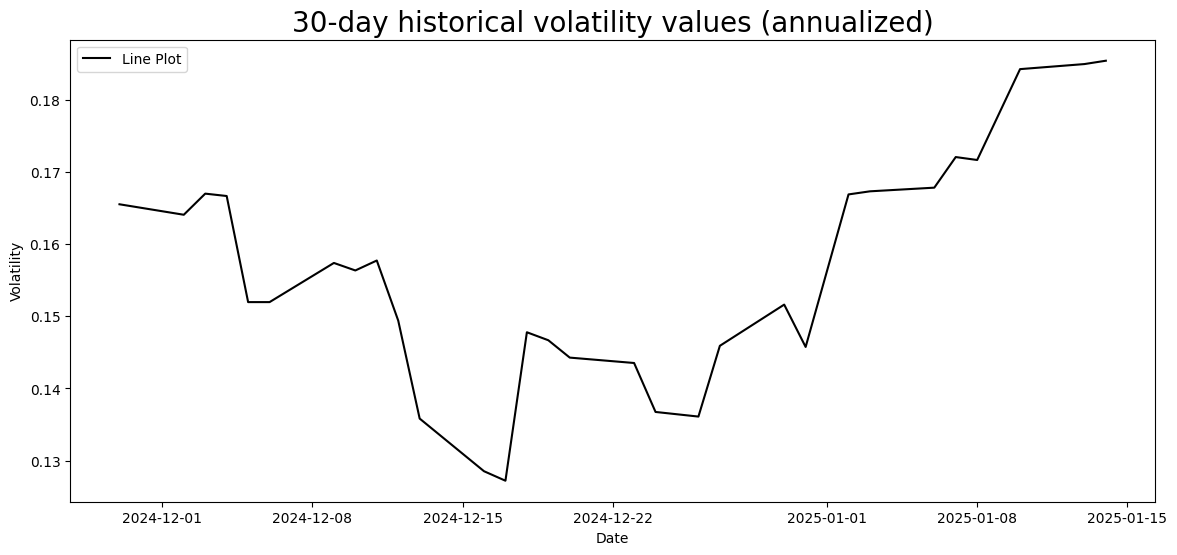

In [60]:
hist_vol("AAPL",30)

#### GARCH Conditional Volatility

Fit and plot of conditional volatility based on GARCH(1,1):

In [61]:
def garch_vol(ticker,train_period = 1000,graph_window=22,forecast_horizon=3):
    ticker_data = yf.download(ticker)
    ticker_data = ticker_data.Close[-train_period:]
    log_ret = np.log(ticker_data/ticker_data.shift()).dropna()
    model = arch_model(log_ret,p=1,q=1)
    model_fit = model.fit(disp="off")
    c_vol = model_fit.conditional_volatility*np.sqrt(252)
    pred = model_fit.forecast(horizon=forecast_horizon)
    vol_pred_values = np.sqrt(pred.variance.values[-1])*np.sqrt(252)
    pred_index = pd.date_range(date.today(),date.today()+timedelta(forecast_horizon-1))
    pred_df = pd.DataFrame(vol_pred_values,index=pred_index)
    
    all_values = np.concatenate([c_vol,vol_pred_values])
    start_date = datetime.date(c_vol.index[0])
    end_date = date.today()+timedelta(forecast_horizon-1)
    index_all = c_vol.index.append(pd.bdate_range(start=date.today(),end = date.today()+timedelta(forecast_horizon-1)))

    all_values_df = pd.DataFrame(all_values,index = index_all)
    plt.figure(figsize=(12,6))
    plt.plot(all_values_df[-graph_window:])
    plt.plot(pred_df,color = "red")
    plt.axvline(date.today(),color = "grey",linestyle = "--")

### Greeks

In [62]:
r = 0.01
S = 30
K = 40
t = 240/365
sigma = 0.3

In [63]:
option_price

<function __main__.option_price(sigma, S, K, r, t, type='c')>

In [64]:
option_price(sigma,S,K,r,t,type = "c")

np.float64(0.5132843798399414)

#### Delta

$delta = \frac{\partial P}{\partial S}$ \
$delta(call) = \Phi(d_1)$ > 0 \
$delta(put) = -\Phi(-d_1) < 0$

In [65]:
def delta(sigma, S, K, r, t,type = "c"):
    d1 = (np.log(S/K) + (r+0.5*sigma**2)*t)/(sigma*np.sqrt(t))
    if type == "c":
        delta_value = norm.cdf(d1)
    elif type == "p":
        delta_value = - norm.cdf(-d1)
    return delta_value

#### Gamma

$Gamma = \frac{\partial Delta}{\partial S^2}$ 

$Gamma = \frac{\phi(d_1)}{S\sigma\sqrt{t}}$

In [66]:
def gamma(sigma, S, K, r, t,type = "c"):
    d1 = (np.log(S/K) + (r+0.5*sigma**2)*t)/(sigma*np.sqrt(t))
    gamma_value = (norm.pdf(d1))/(S*sigma*np.sqrt(t))
    return gamma_value

### Vega

$Vega = \frac{\partial P}{\partial \sigma}$ 

We have already defined vega, function: calculate_vega 

- it was neccessary(as an input for the Newton's algortihm), since it is a derivative of the option price w.r.t. $\sigma$
- function name: calculate_vega

In [67]:
calculate_vega

<function __main__.calculate_vega(sigma, args)>

#### Theta

$Theta = - \frac{\partial P}{\partial t}$ 

call: $Theta = -\frac{S \phi(d_1)\sigma}{2t} - rKexp(-rt)\Phi(d_2)$

put: $Theta = -\frac{S \phi(d_1)\sigma}{2t} + rKexp(-rt)\Phi(-d_2)$

In [68]:
def theta(sigma, S, K, r, t,type = "c"):
    d1 = (np.log(S/K) + (r+0.5*sigma**2)*t)/(sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)
    if type == "c":
        theta_value = ((-S*norm.pdf(d1)*sigma)/(2*t)) - r*K*np.exp(-r*t)*norm.cdf(d2)
    elif type == "p":
        theta_value = ((-S*norm.pdf(d1)*sigma)/(2*t)) + r*K*np.exp(-r*t)*norm.cdf(-d2)
    return theta_value/365 #to obtain time decay per day, not years

### Rho

$Rho = \frac{\partial P}{\partial r}$

call: $Rho = KTexp(-rt)\Phi(d_2) > 0$ 

 put: $Rho = -KTexp(-rt)\Phi(-d_2) < 0$ 

In [69]:
def rho(sigma, S, K, r, t,type = "c"):
    d1 = (np.log(S/K) + (r+0.5*sigma**2)*t)/(sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)
    if type == "c":
        rho_value = K*t*np.exp(-r*t)*norm.cdf(d2)
    elif type == "p":
        rho_value = -K*t*np.exp(-r*t)*norm.cdf(-d2)
    return rho_value*0.01 #to obtain sensitivity to 1% change in rates

### Vega

$Vega = \frac{\partial P}{\partial \sigma}$ \
$Vega = S \phi(d_1) \sqrt{t}$

In [70]:
def vega(sigma, S, K, r, t,type = "c"):
    d1 = (np.log(S/K) + (r+0.5*sigma**2)*t)/(sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)
    vega_value = S*norm.pdf(d1,0,1)*np.sqrt(t)
    return vega_value
    


In [71]:
greek_fun = {"delta":delta,
                 "gamma":gamma,
                 "rho":rho,
                 "theta":theta,
                 "vega":vega}
def greeks(sigma, S, K, r, t,type):
    result = {name: func(sigma, S, K, r, t,type) for name,func in greek_fun.items()}
    return pd.DataFrame([result]).reset_index(drop=True)

---------------------------------------------------------------------------- 

---------------------------------------------------------------------------- 

----------------------------------------------------------------------------


# Final Screen

Function: hist_vol \
Insert a ticker and a length of a window to obtain values for historical volatility for the last month:

[*********************100%***********************]  1 of 1 completed

The last value of historical volatility based on 60-day window is 0.1731


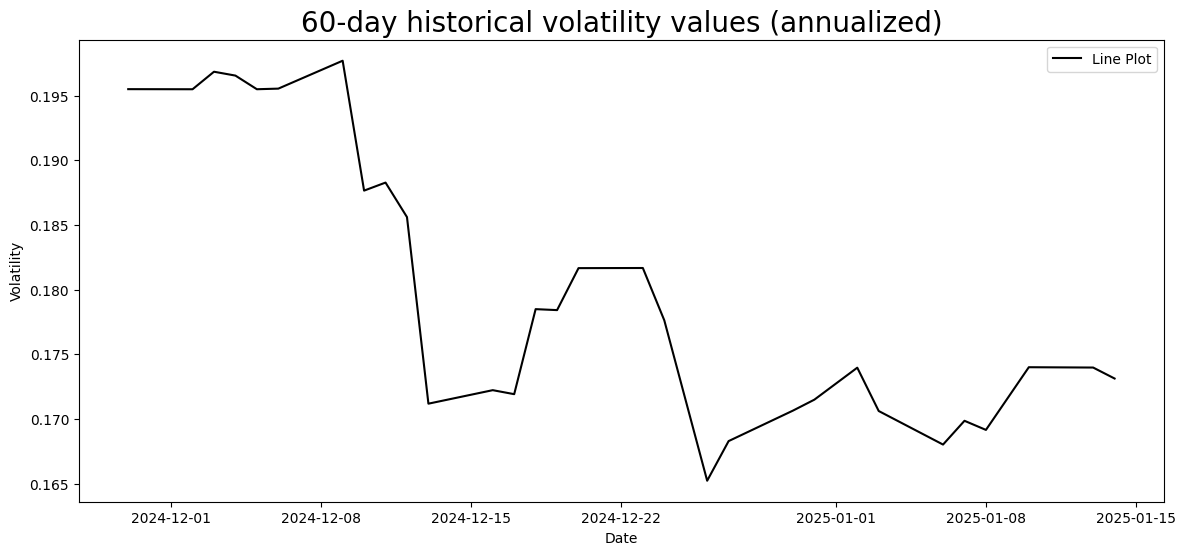

In [72]:
hist_vol("AAPL",60)

Function: garch_vol \


[*********************100%***********************]  1 of 1 completed


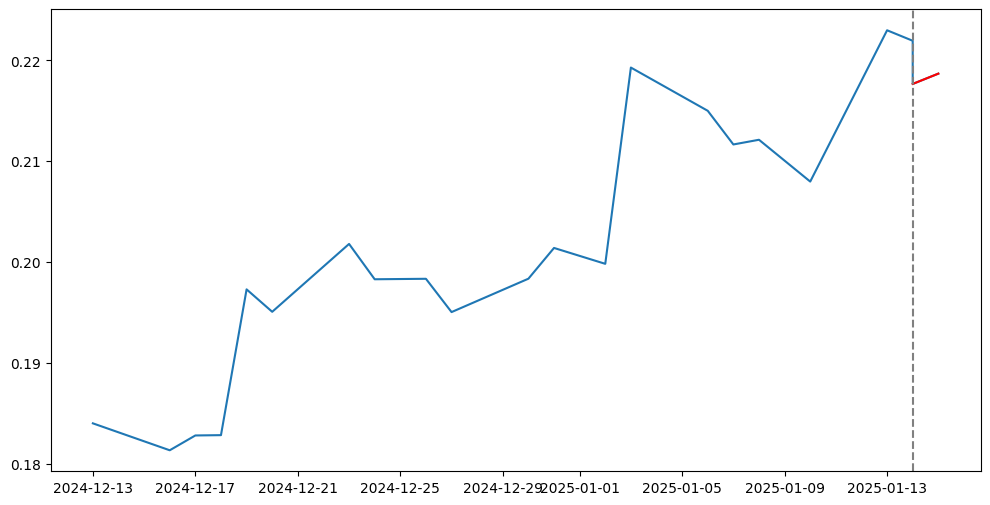

In [82]:
garch_vol("AAPl",train_period=1000,graph_window=22,forecast_horizon=2)

Function: greeks \
Insert volatility, spot price, strike price, interest rate, time (years) to expiration and type of the option(c = call, p = put) \
Obtain a data frame with option greeks: delta, gamma, rho, theta, vega

In [74]:
greeks(sigma= 0.2,S = 100,K = 100,r = 0.05,t = 10/365,type = "c")

,delta,gamma,rho,theta,vega
0,0.523099,0.120309,0.013951,-0.405249,6.592268


Function: options_data \
Insert a ticker, required option type, lower bound for open interest in given options(excludes scarcely traded options, with open interest being below the given lower bound)

In [75]:
ticker = "AAPL" #Input the required ticker
option_type = "call" #The calculation is adapted for call options
oi_lower_bound = 0 #Input the required lower bound of the open interest

In [76]:
S_ticker = yf.download(ticker)["Close"].iloc[-1].iat[-1] #The last closing price for the given ticker
r_1y = yf.download("^IRX")["Close"].iloc[-1].iat[-1]/100 #Interest rate for the calculation, based on US-Treasury 1-year yield
print(f"The latest available spot price of the specified ticker is {round(S_ticker,4)}")
print(f"The interest rate used in th calculation is {round(r_1y*100,4)}%")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

The latest available spot price of the specified ticker is 235.3929
The interest rate used in th calculation is 4.218%


In [77]:
data_options = options_data(ticker,option_type,oi_lower_bound).dropna()
data_options["iv"] = data_options.apply(lambda row: newtons_method(objective_function,calculate_vega,0.5,
                                                       args=(S_ticker,row["strike"],r_1y,float(row["dte"]/365),row["lastPrice"])),axis = 1)

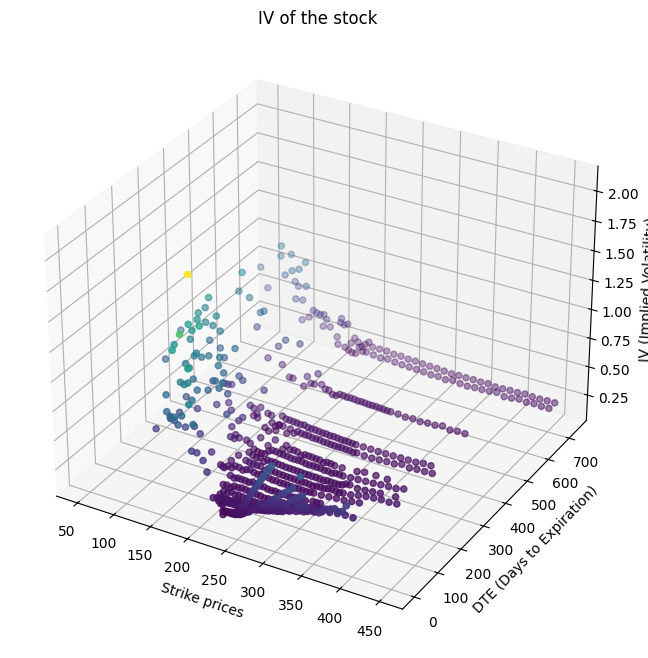

In [80]:
plot_iv_values(data_options)

In [81]:
plot_iv_values_inter(data_options)

To do: \
2) add an option to add lines to the plots, e.g. S, and volatilities \
3) spend some time with the graphical side of those plots... \
4) adaptive interest rate?...so that the US-t yield would match the option maturity
